In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import glob

Data Pipeline

In [2]:
filepaths = glob.glob('datasets\Tumor\yes\*.jpg') + glob.glob('datasets\Tumor\yes\*.JPG') +glob.glob('datasets\Tumor\yes\*.png')
filepaths_negative =   glob.glob('datasets\\Tumor\\no\\*.jpg') + glob.glob('datasets\\Tumor\\no\\*.jpeg')

In [3]:
def preprocess_to_tensors(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img.set_shape([None, None, 3])
        img = tf.image.resize(img , [218, 180])
        return img
    except tf.errors.InvalidArgumentError:
        # Skip files that are not in a supported format
        return None

In [4]:
def preprocess_to_tensors_no(file_path):
    img = tf.io.read_file(tf.cast(file_path, tf.string))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize_with_pad(img, 218, 180)
    return img

In [5]:
imgtensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(filepaths)
dataset = dataset.map(preprocess_to_tensors)
for img in dataset:
    imgtensorarray = imgtensorarray.write(imgtensorarray.size(), img)

train_yes = imgtensorarray.stack()

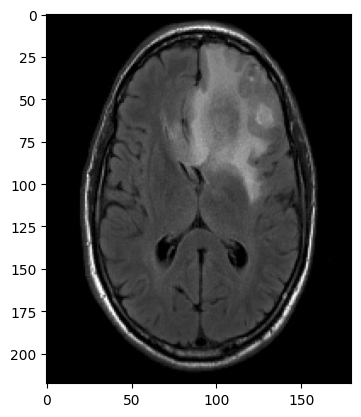

In [7]:
plt.figure()
plt.imshow(train_yes[68])

In [8]:
train_yes.shape

TensorShape([309, 218, 180, 3])

In [9]:
dataset_negative = tf.data.Dataset.from_tensor_slices(filepaths_negative)
dataset_negative = dataset_negative.map(preprocess_to_tensors_no)

In [10]:
img_negative_tensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)
for neg_img in dataset_negative:
    img_negative_tensorarray = img_negative_tensorarray.write(img_negative_tensorarray.size(), neg_img)


train_no = img_negative_tensorarray.stack()

In [11]:
train_no.shape

TensorShape([97, 218, 180, 3])

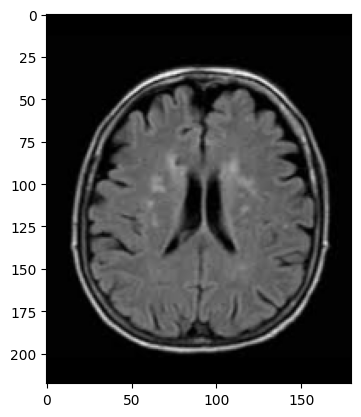

In [12]:
plt.imshow(train_no[6])

In [13]:
train_x = tf.concat([train_yes, train_no], axis = 0)
train_x.shape

TensorShape([406, 218, 180, 3])

In [14]:
y_yes = tf.ones(train_yes.shape[0], 1)
y_no = tf.zeros(train_no.shape[0], 1)

In [15]:
train_y = tf.concat([y_yes,y_no], axis = 0)

In [16]:
train_y = tf.reshape(train_y, (train_y.shape[0], 1))

In [17]:
train_y.shape

TensorShape([406, 1])

In [18]:
permutation = tf.random.shuffle(tf.range(tf.shape(train_x)[0]))
train_x = tf.gather(train_x , permutation)
train_y = tf.gather(train_y, permutation)

### Utility Functions:

In [19]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='my_logs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

run_logdir = get_run_logdir()

## Model

In [24]:
class TumorDetectionNeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.base_preprocess_ = tf.keras.applications.xception.preprocess_input
        self.base_model = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=False)
        self.base_model.trainable = False
        self.avg = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_1 = tf.keras.layers.Dense(256 , activation = tf.keras.activations.relu,
                                        kernel_initialzer = tf.keras.initializers.GlorotNormal() )
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.dense_2 = tf.keras.layers.Dense(128, activation = tf.keras.activations.relu , 
                                        kernerl_initializer = tf.keras.initializers.GlorotNormal() )
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.output = tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)

    def call(self, input , training = False):
        x = self.base_preprocess_(input, training = training)
        avg_ = self.avg(x)
        ff1 = self.dense_1(avg_)
        ff1 = self.drop1(ff1)
        ff2 = self.dense_2(ff1)
        ff2 = self.drop2(ff2)
        out = self.output(ff2)

In [25]:
class DelayModelGraph(tf.keras.callbacks.Callback):
    def __init__(self, graph_begin ,**kwargs):
        super().__init__(**kwargs)
        self.graph_begin = graph_begin

    def on_epoch_begin(self, epoch , logs = None):
        if epoch == self.graph_begin:
            for layer in self.model.base_model.layers:
                layer.trainable = True
            self.model.compile(optimizer = tf.keras.optimizers.Adam(1e-5),
                               loss = tf.keras.losses.binary_crossentropy,
                               metrics = ['accuracy'])    